## ECGR5106 HW 3

In [1]:
# Installing the d2l Module and ptflops
!pip install d2l==1.0.0b0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.4 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616822 sha256=a96538f35ac680e4ac36aa9a8bdcc7af571eee06bc990292063a83e850fcf831
  Stored in directory: /root/.cache/pip/wheels/27/6d/b3/a3a6e10704795c9b9000f1ab2dc480dfe7bed42f5972806e73
Successfully built gym
  Attempting uninstal

In [2]:
# Importing all the Necessary Libraries

%matplotlib inline
import pandas as pd
import numpy as np
import ptflops

import matplotlib.pyplot as plt
import torch
import time
import torchvision
import torch.nn.functional as F   
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torchvision.models as models
from ptflops import get_model_complexity_info

import torch
torch.__version__
torch.cuda.current_device()
torch.cuda.get_device_name(0)

d2l.use_svg_display()

# Code Snippet to Ignore Warning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading the CIFAR-10 Dataset 
class CIFAR10(d2l.DataModule): 
  def __init__(self, resize, batch_size = 64):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.CIFAR10(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.CIFAR10(
        root = self.root, train = False, transform = trans, download = True)

In [4]:
# Resizing the Images to 64x64
data = CIFAR10(resize = (64, 64))
# Printing the # of Training & Validation Images
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified
Training Images   =  50000
Validation Images =  10000


torch.Size([3, 64, 64])

In [5]:
# Function that Converts the Numeric Labels to 10 Different Class Names
@d2l.add_to_class(CIFAR10)
def text_labels(self, indices):
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']
  return [labels[int(i)] for i in indices]

# Function to load either Training or Validation self
@d2l.add_to_class(CIFAR10)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle = train,
                                     num_workers = self.num_workers)
  
X, Y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, Y.shape, Y.dtype)

torch.Size([64, 3, 64, 64]) torch.float32 torch.Size([64]) torch.int64


In [6]:
# Function to Evaluate the Model's Accuracy
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [7]:
# Training Function 
def train(net, train_iter, val_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))

## Problem 1

For Problem 1, the CIFAR-10 Dataset will be used which comes with all 3 RGB Input Channels. 

1. The Baseline VGG model  needed for FashionMNIST will be trained on CIFAR-10 and the  Validation Accuracy, as well as the Training Loss and Accuracy will be reported. For the training, the network input will be resized to 64*64 resolution.
2. Using Table 1 in the VGG paper (Simonyan and Zisserman, 2014) other common models, like VGG-16 or VGG-19 will be constructed. The models will be trained on CIFAR-10 and the accuracies, computational complexity and memory size will be compared.

In [ ]:
# Defining the VGG Block (Function)
def vgg_block(num_convs, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size = 3, padding = 1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
  return nn.Sequential(*layers)

In [ ]:
# Baseline VGG Network
class VGG(d2l.Classifier):
  def __init__(self, arch, lr = 0.1, num_classes = 10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    for(num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [ ]:
# Function to print a Model's Layer Summary given the shape
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  34.44 M, 100.000% Params, 637.99 MMac, 100.000% MACs, 
  (0): Sequential(
    1.79 k, 0.005% Params, 7.86 MMac, 1.233% MACs, 
    (0): Conv2d(1.79 k, 0.005% Params, 7.34 MMac, 1.150% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.041% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 262.14 KMac,

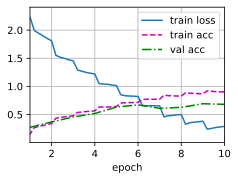

In [ ]:
# Plotting the Baseline VGG Model over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
# Defining Model for VGG-16 (16 Layers)
model = VGG(arch=((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  39.93 M, 100.000% Params, 1.28 GMac, 100.000% MACs, 
  (0): Sequential(
    38.72 k, 0.097% Params, 159.38 MMac, 12.445% MACs, 
    (0): Conv2d(1.79 k, 0.004% Params, 7.34 MMac, 0.573% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.020% MACs, )
    (2): Conv2d(36.93 k, 0.092% Params, 151.26 

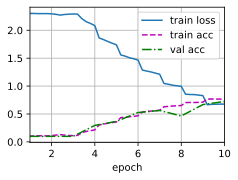

In [ ]:
# Plotting the VGG-16 Model over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
# Defining Model for VGG-19 (19 Layers)
model = VGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  45.24 M, 100.000% Params, 1.62 GMac, 100.000% MACs, 
  (0): Sequential(
    38.72 k, 0.086% Params, 159.38 MMac, 9.834% MACs, 
    (0): Conv2d(1.79 k, 0.004% Params, 7.34 MMac, 0.453% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.016% MACs, )
    (2): Conv2d(36.93 k, 0.082% Params, 151.26 M

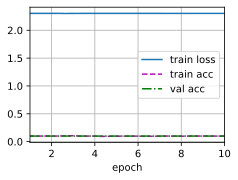

In [ ]:
# Plotting the VGG-19 Model over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 2

1. Using the CIFAR-10, a baseline Classifier will be trained based on the GoogleNet model for a 64*64 input resolution. Validation Accuracy, as well as the Training Loss and Accuracy will be reported.
2. A Batch Normalization layer will be added to GoogleNet. Training again, Validation Accuracy, as well as the Training Loss and Accuracy will be reported. Reults will be compared against Problem 2.1.

In [18]:
# Defining the Inception Class with 4 Branches
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [19]:
# Defining the the Stem of GoogLeNet
class GoogleNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# Defining the Body of the GoogLeNet
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [20]:
# Defining the 3rd Module of GoogLeNet (with 2 Inception Blocks)
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [21]:
# Defining the 4th Module of GoogLeNet (with 5 Inception Blocks)
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [22]:
# Defining the 5th Module of GoogLeNet (with 2 Inception Blocks)
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [23]:
# Connect all the Blocks together
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

model = GoogleNet()
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 192, 8, 8])
Sequential output shape:	 torch.Size([64, 480, 4, 4])
Sequential output shape:	 torch.Size([64, 832, 2, 2])
Sequential output shape:	 torch.Size([64, 1024])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  5.98 M, 100.000% Params, 129.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.47 k, 0.158% Params, 9.83 MMac, 7.576% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.475% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(0, 0.000% Params, 65.54 KMac, 0.051% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.051% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    114.94 k, 1.921% Params, 29.54 MMac, 22.766% MACs, 
    (0): Conv2d(4.16 k, 0.070% Params, 1.06 MMac, 0.821% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(0, 0.000% Params, 16.38 KMac, 0.013% MACs, )
  

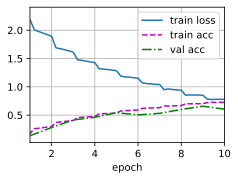

In [ ]:
# Plotting the GoogLeNet Model over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [35]:
# Repetation of Previous Model, with Bach Normalization Added
# Defining the Inception Class with 4 Branches
# Defining the Inception Class with 4 Branches
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        self.bn1_1 = nn.BatchNorm2d(c1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.bn2_1 = nn.BatchNorm2d(c2[0])
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(c2[1])
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.bn3_1 = nn.BatchNorm2d(c3[0])
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        self.bn3_2 = nn.BatchNorm2d(c3[1])
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
        self.bn4_2 = nn.BatchNorm2d(c4)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [36]:
# Defining the the Stem of GoogLeNet
class GoogleNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# Defining the Body of the GoogLeNet
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.BatchNorm2d(64), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.BatchNorm2d(192), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [42]:
# Defining the 3rd Module of GoogLeNet (with 2 Inception Blocks)
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# Defining the 4th Module of GoogLeNet (with 5 Inception Blocks)
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# Defining the 5th Module of GoogLeNet (with 2 Inception Blocks)
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

# Connect all the Blocks together
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [43]:
# Printing the Model Summary and Model Complexity
model = GoogleNet()
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 192, 8, 8])
Sequential output shape:	 torch.Size([64, 480, 4, 4])
Sequential output shape:	 torch.Size([64, 832, 2, 2])
Sequential output shape:	 torch.Size([64, 1024])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  6.0 M, 100.000% Params, 130.02 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.160% Params, 9.96 MMac, 7.662% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.460% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.002% Params, 131.07 KMac, 0.101% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.050% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.050% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    115.46 k, 1.925% Params, 29.67 MMac, 22.821% MACs, 
    (0): Conv2d(4.16 k, 0.069% Par

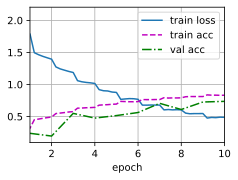

In [44]:
# Plotting the GoogLeNet Model over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Problem 3

1. The baseline Model done is called ResNet-18. This will be trained for CIFAR-10 and Validation Accuracy, as well as the Training Loss and Accuracy will be reported and compared against GoogleNet and VGGNet architectures. 

Can the training time, model size, and computational complexity across these 3 networks for CIFAR-10 be compared? (64*64 input resolution will be used across all trainings)

2. Two new version of ResNet, ResNet-26 and ResNet-32, will be built. Training them on CIFAR-10, the training loss, training accuracy, and validation accuracy will be plotted. The classification(validation) accuracy, computation complexity, and model size will be compared across these 3 versions of ResNet(18, 26, & 32).

How does the complexity grow as the network depth is increased?

In [ ]:
# Defining the Residual Block
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
# Defining the ResNet Class (The 1st Block of ResNet Model)
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# Defining the Block Structure for ResNet Model (Can be called multiple times as needed)
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)
# Combines the 1st Block, the center Block Structure and Final Layers 
# to make the ResNet Architecture 
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
# Defining the ResNet-18 Model (a Total of 18 Layers)
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

model = ResNet18()
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  11.18 M, 100.000% Params, 148.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.086% Params, 9.96 MMac, 6.696% MACs, 
    (0): Conv2d(9.47 k, 0.085% Params, 9.7 MMac, 6.520% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.044% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    148.22 k, 1.325% Params, 37.95 MMac, 25.507% MACs, 
    (0): Residual(
  

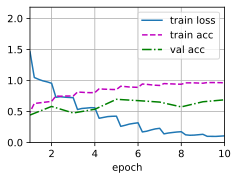

In [ ]:
# Plotting the Baseline ResNet Model (ResNet-18) over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
# Defining the ResNet-26 Model (a Total of 26 Layers)
class ResNet26(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 256), (2, 512), (2, 512)),
                       lr, num_classes)

model = ResNet26()
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 256, 2, 2])
Sequential output shape:	 torch.Size([64, 512, 1, 1])
Sequential output shape:	 torch.Size([64, 512, 1, 1])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  23.32 M, 100.000% Params, 142.99 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.041% Params, 9.96 MMac, 6.966% MACs, 
    (0): Conv2d(9.47 k, 0.041% Params, 9.7 MMac, 6.783% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.092% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.046% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.046% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=

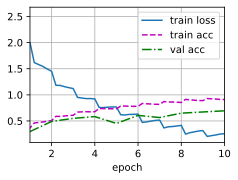

In [ ]:
# Plotting the Modified ResNet Model (ResNet-26) over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [ ]:
# Defining the ResNet-32 Model (a Total of 32 Layers)
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 64), (1, 128), (2, 128), (2, 256), (2, 256), (2, 512), (2, 512)),
                       lr, num_classes)

model = ResNet32()
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 8, 8])
Sequential output shape:	 torch.Size([64, 128, 4, 4])
Sequential output shape:	 torch.Size([64, 128, 2, 2])
Sequential output shape:	 torch.Size([64, 256, 1, 1])
Sequential output shape:	 torch.Size([64, 256, 1, 1])
Sequential output shape:	 torch.Size([64, 512, 1, 1])
Sequential output shape:	 torch.Size([64, 512, 1, 1])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  23.78 M, 100.000% Params, 86.41 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.040% Params, 9.96 MMac, 11.528% MACs, 
    (0): Conv2d(9.47 k, 0.040% Params, 9.7 MMac, 11.225% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.152% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.076% MACs, )
    (3): Max

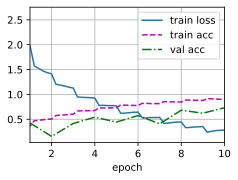

In [ ]:
# Plotting the Modified ResNet Model (ResNet-32) over 10 Epochs
# This plot contains Trainging Loss,Training Accuracy, and Test (Validation) Accuracy
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

## Bonus Problem

For the Bonus Problem, Using ResNet-18 Model Structure as a starting point, the DenseNet Model will be modified for it to have around the same Model Complexity as ResNet-18. 

In [ ]:
# Defining the Convolution Block Structure
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

# Defini
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

# Defining the  Transition Block
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [ ]:
# Defining the DenseNet Class
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(256, kernel_size = 11, stride = 3, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size = 11, stride = 2, padding=3))

@d2l.add_to_class(DenseNet)
def __init__(self, num_channels= 64, growth_rate = 128, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [ ]:
model = DenseNet()
model.layer_summary((64, 3, 64, 64))
# Printing the total Number of MACs and Parameters for the Model
macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 256, 8, 8])
DenseBlock output shape:	 torch.Size([64, 768, 8, 8])
Sequential output shape:	 torch.Size([64, 288, 4, 4])
DenseBlock output shape:	 torch.Size([64, 800, 4, 4])
Sequential output shape:	 torch.Size([64, 400, 2, 2])
DenseBlock output shape:	 torch.Size([64, 912, 2, 2])
Sequential output shape:	 torch.Size([64, 456, 1, 1])
DenseBlock output shape:	 torch.Size([64, 968, 1, 1])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  11.08 M, 100.000% Params, 240.81 MMac, 100.000% MACs, 
  (0): Sequential(
    93.7 k, 0.846% Params, 37.68 MMac, 15.649% MACs, 
    (0): Conv2d(93.18 k, 0.841% Params, 37.27 MMac, 15.478% MACs, 3, 256, kernel_size=(11, 11), stride=(3, 3), padding=(3, 3))
    (1): BatchNorm2d(512, 0.005% Params, 204.8 KMac, 0.085% MACs, 256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 102.4 KMac, 0.043% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 102.4 KMac, 0.043% MA